# S2S Kenya - Zonal statistics

Zonal statistics are run on the standardized [H3 grid](https://h3geo.org/docs/core-library/restable/); the process is run on a country-by-country basis.

For the zonal statistics, each zonal statistic is run against the source dataset as a whole, then it is stratified by urban classification from the European Commission - [GHS-SMOD](https://ghsl.jrc.ec.europa.eu/ghs_smod2019.php). This creates an summary dataset that has the standard zonal stats columns (SUM, MEAN, MAX, MIN) as well as the same for urban areas (SUM_urban, MEAN_urban, MAX_urban, MIN_urban).

In [2]:
import sys, os, importlib, math, multiprocessing
import rasterio, geojson

import pandas as pd
import geopandas as gpd
import numpy as np

from h3 import h3
from tqdm import tqdm
from shapely.geometry import Polygon

sys.path.insert(0, "/home/wb411133/Code/gostrocks/src")
import GOSTRocks.rasterMisc as rMisc
import GOSTRocks.ntlMisc as ntl
import GOSTRocks.mapMisc as mapMisc
from GOSTRocks.misc import tPrint

sys.path.append("../src")
import h3_helper
import country_zonal

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sel_iso3 = "KEN"
h3_level = 6

admin_bounds = "/home/public/Data/GLOBAL/ADMIN/ADMIN2/HighRes_20230328/shp/WB_GAD_ADM2.shp"
out_folder = f"/home/wb411133/projects/Space2Stats/{sel_iso3}"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
global_urban = "/home/public/Data/GLOBAL/GHSL/SMOD/GHS_SMOD_E2020_GLOBE_R2023A_54009_1000_V1_0.tif"

In [4]:
inA = gpd.read_file(admin_bounds)
selA = inA.loc[inA['ISO_A3'] == sel_iso3].copy()
selA['ID'] = selA.index #Create ID for indexing

inU = rasterio.open(global_urban)

In [5]:
# As a demo, we will begin with nighttime lights layers
ntl_layers = ntl.aws_search_ntl()
ntl_file = ntl_layers[-1]

# Generate zonal statistics at h3 based on urbanization levels

In [59]:
def get_per(x):
    try:
        return(x['SUM_urban']/x['SUM'] * 100)
    except:
        return(0)

## Population

In [65]:
global_pop_layer = "/home/public/Data/GLOBAL/GHSL/Pop/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0.tif"
#popR = rasterio.open(global_pop_layer)
#popR.profile

In [80]:
zonalC = country_zonal.country_h3_zonal(sel_iso3, selA, "ID", h3_level, out_folder)
zonal_res_pop = zonalC.zonal_raster_urban(global_pop_layer, global_urban)

In [85]:
map_data_pop = zonal_res_pop.sort_values("SUM_urban").loc[:,['shape_id','SUM','SUM_urban']].copy()
map_data_pop = pd.merge(zonalC.h3_cells, map_data_pop, on='shape_id')
map_data_pop['per_urban'] = map_data_pop.apply(get_per, axis=1)
map_data_pop.sort_values('SUM')

,shape_id,index_right,NAM_1,GAUL_2,NAM_2,geometry,SUM,SUM_urban,per_urban
0,867a42747ffffff,36824,Marsabit,0,Laisamis,"POLYGON ((38.14369 1.55168, 38.15556 1.58313, ...",0.000000e+00,0.0,0.000000
2802,867a46c1fffffff,36689,Garissa,0,Balambala,"POLYGON ((39.22998 0.19729, 39.24169 0.22906, ...",0.000000e+00,0.0,0.000000
7501,867a512d7ffffff,36894,Marsabit,0,North Horr,"POLYGON ((38.44169 2.51242, 38.45345 2.54352, ...",0.000000e+00,0.0,0.000000
2806,866a58ae7ffffff,36955,Turkana,0,Turkana West,"POLYGON ((34.84366 4.46588, 34.85599 4.49660, ...",0.000000e+00,0.0,0.000000
7494,867a66b17ffffff,36734,Tana River,0,Garsen,"POLYGON ((39.17285 -2.98710, 39.18473 -2.95444...",0.000000e+00,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
4746,867a6e417ffffff,36913,Nairobi,0,Roysambu,"POLYGON ((36.93423 -1.21823, 36.94647 -1.18585...",4.574501e+05,455681.0,99.613269
9348,867a6e407ffffff,36913,Nairobi,0,Roysambu,"POLYGON ((36.88711 -1.25555, 36.89936 -1.22315...",5.515042e+05,549574.0,99.650015
12245,867a6e55fffffff,36781,Nairobi,0,Kibra,"POLYGON ((36.79280 -1.33023, 36.80507 -1.29781...",5.933135e+05,591558.0,99.704123
6380,867a6e437ffffff,36772,Nairobi,0,Kasarani,"POLYGON ((36.94461 -1.27810, 36.95685 -1.24570...",7.745367e+05,772815.0,99.777711


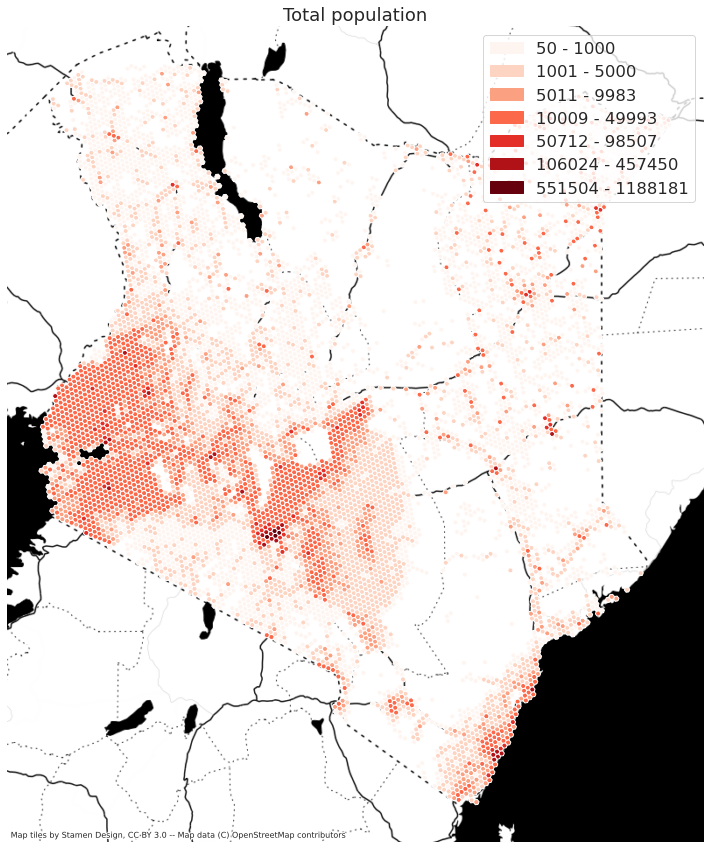

In [90]:
map_plt = mapMisc.static_map_vector(map_data_pop, "SUM", thresh=[50, 1000, 5000, 10000, 50000, 100000, 500000, 1500000], figsize=(15, 15))
map_plt.title("Total population")
map_plt.show()

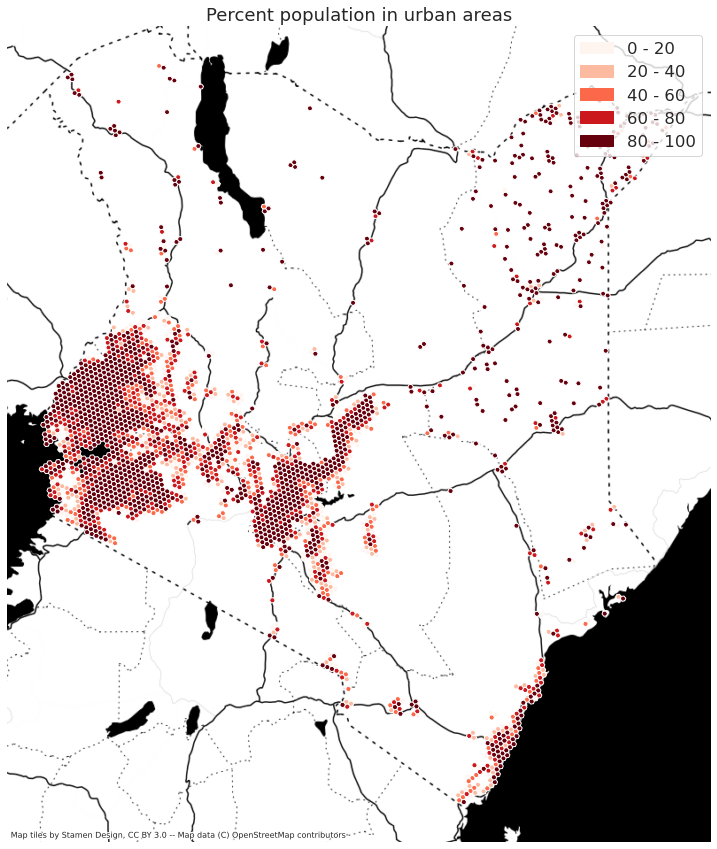

In [91]:
map_plt = mapMisc.static_map_vector(map_data_pop, "per_urban", thresh=[0, 20, 40, 60, 80, 100, 1000], figsize=(15,15))
map_plt.title("Percent population in urban areas")
map_plt.show()

## Nighttime Lights

In [6]:
zonalC = country_zonal.country_h3_zonal(sel_iso3, selA, "ID", h3_level, out_folder)

In [8]:
zonal_res = zonalC.zonal_raster_urban(ntl_file, global_urban)

In [92]:
map_data = zonal_res.sort_values("SUM_urban").loc[:,['shape_id','SUM','SUM_urban']].copy()
map_data = pd.merge(zonalC.h3_cells, map_data, on='shape_id')
map_data['per_urban'] = map_data.apply(get_per, axis=1)
map_data.sort_values('SUM')

,shape_id,index_right,NAM_1,GAUL_2,NAM_2,geometry,SUM,SUM_urban,per_urban
6351,866a58a67ffffff,36955,Turkana,0,Turkana West,"POLYGON ((34.92733 4.59296, 34.93965 4.62362, ...",36.120003,0.0,0.000000
8183,866a59b0fffffff,36953,Turkana,0,Turkana North,"POLYGON ((35.87276 4.59425, 35.88490 4.62484, ...",37.129997,0.0,0.000000
1634,866a59857ffffff,36953,Turkana,0,Turkana North,"POLYGON ((35.61105 4.59085, 35.62324 4.62146, ...",39.250000,0.0,0.000000
2795,866a58bafffffff,36955,Turkana,0,Turkana West,"POLYGON ((34.66464 4.58921, 34.67700 4.61989, ...",39.839996,0.0,0.000000
12170,867ae185fffffff,36844,Mandera,0,Mandera North,"POLYGON ((40.98292 3.56723, 40.99410 3.59766, ...",40.509998,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
11618,867a6e42fffffff,36968,Nairobi,0,Westlands,"POLYGON ((36.83997 -1.29288, 36.85223 -1.26047...",4407.709961,4147.0,94.085138
12431,867b59b2fffffff,36711,Mombasa,0,Changamwe,"POLYGON ((39.63531 -4.06321, 39.64715 -4.03034...",4457.299805,3930.0,88.169972
579,867b59b27ffffff,36872,Mombasa,0,Mvita,"POLYGON ((39.69284 -4.08543, 39.70467 -4.05255...",4545.560547,4409.0,96.995738
9201,867a6e427ffffff,36839,Nairobi,0,Makadara,"POLYGON ((36.89748 -1.31544, 36.90974 -1.28303...",6022.190430,5929.0,98.452549


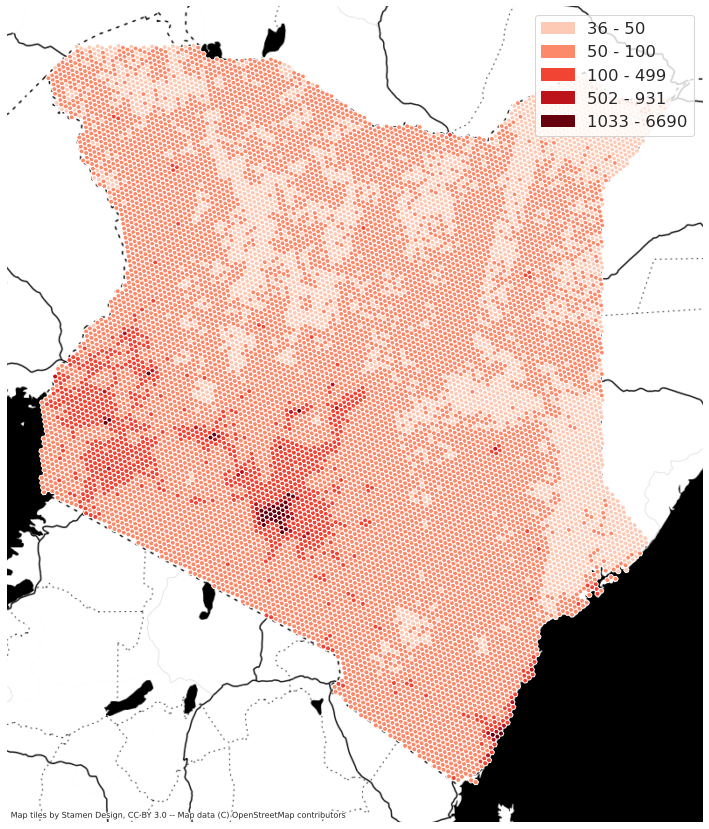

In [93]:
map_plt = mapMisc.static_map_vector(map_data, "SUM", thresh=[5,10,50,100,500,1000,7000], figsize=(15,15))
map_plt.show()

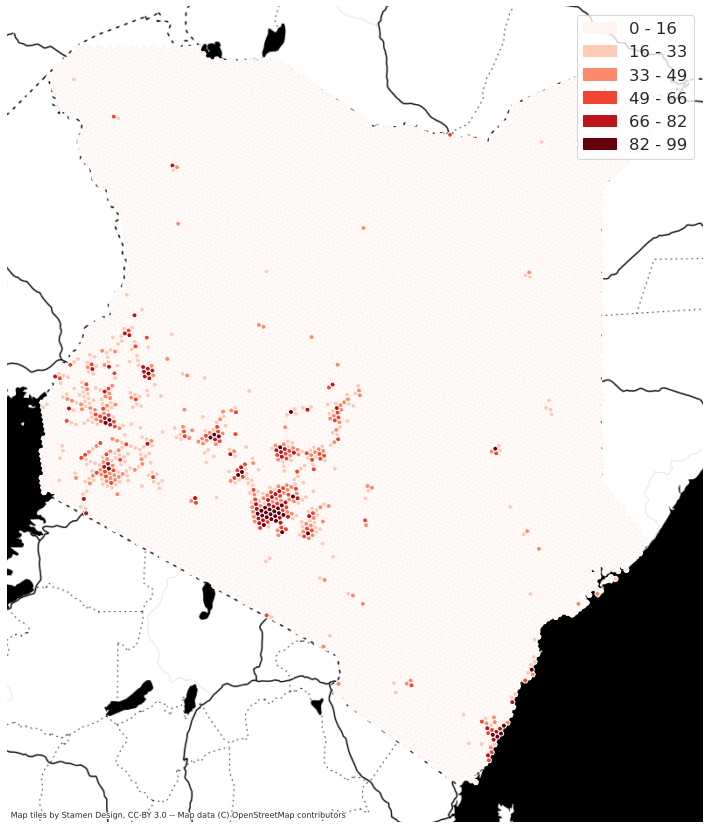

In [94]:
map_plt = mapMisc.static_map_vector(map_data, "per_urban", figsize=(15,15))
map_plt.show()

# Join h3 zonal results to admin boundaries

below we compare timing the administrative summaries with and without fractional intersections. While there is a difference between the two, the overall process is quite fast. As the is no computational limitation, we will rely on the fractional intersection as it is more accurate.

In [50]:
### These two cells are used to test the speed of joining with and without
# %timeit cur_res = country_zonal.connect_polygons_h3_stats(selA, zonal_res, h3_level, "ID", True)

20.6 s ± 62.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
# %timeit cur_res = country_zonal.connect_polygons_h3_stats(selA, zonal_res, h3_level, "ID", False)

16.3 s ± 62.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [102]:
cur_res = country_zonal.connect_polygons_h3_stats(selA, zonal_res_pop, h3_level, "ID", True)

In [106]:
map_admin = pd.merge(selA, cur_res, left_on="ID", right_on='id')
map_admin['per_urban'] = map_admin.apply(get_per, axis=1)

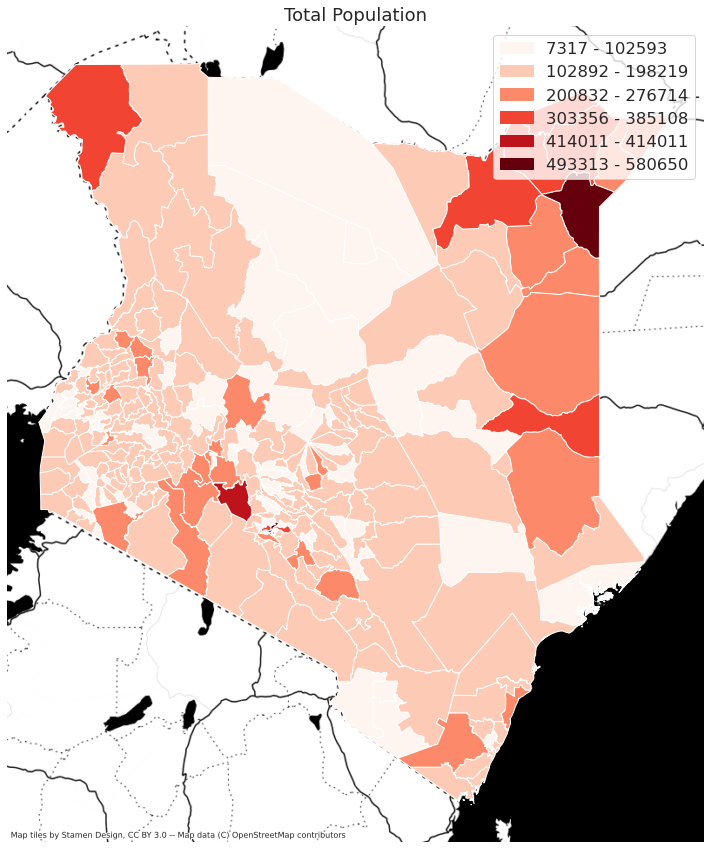

In [105]:
map_plt = mapMisc.static_map_vector(map_admin, "SUM", figsize=(15,15))
map_plt.title("Total Population")
map_plt.show()

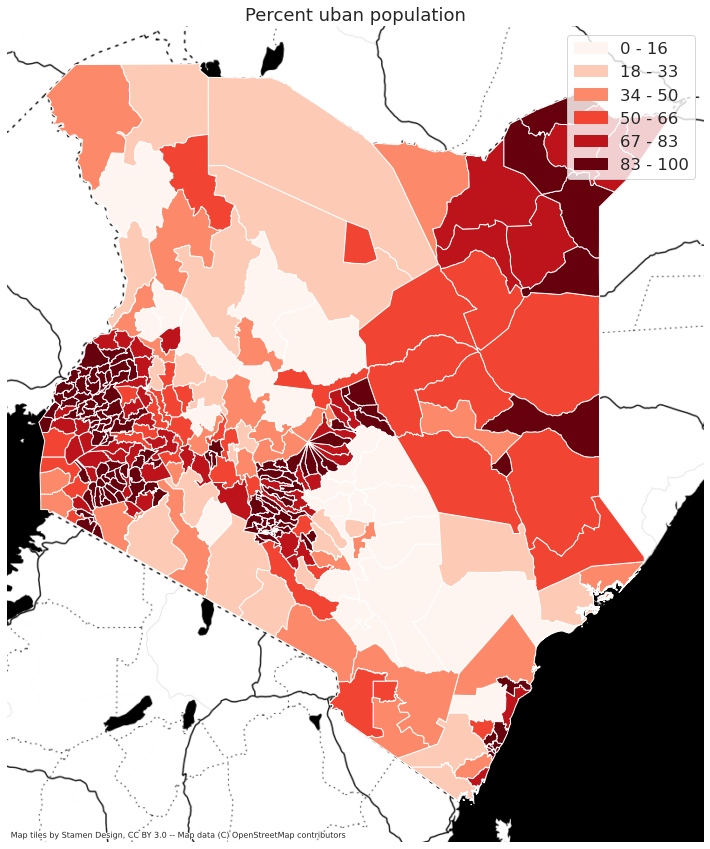

In [107]:
map_plt = mapMisc.static_map_vector(map_admin, "per_urban", figsize=(15,15))
map_plt.title("Percent uban population")
map_plt.show()